In [1]:
import pandas as pd 
import numpy as np 
import os 
import torch 
from torch import nn 
import numpy as np
from datetime import datetime
from torchvision.models.efficientnet import efficientnet_v2_s 
from torch.utils.data import DataLoader, random_split
import pandas as pd
from argparse import Namespace
from tqdm.auto import tqdm
from trainUtils import all_seed, base_config
from dataUtils import speciesRecDataSet, idx2sp, train_add_norm_tfm, test_add_norm_tfm, train_add_norm_simple_tfm

/home/scc/anaconda3/envs/LLM/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


# inference val data

In [2]:
base_config = Namespace(
    device='cuda',
    train_data_dir='/home/scc/sccWork/myGitHub/My_Competition/2024xfyunSpeciesRecognition/data/train',
    test_data_dir='/home/scc/sccWork/myGitHub/My_Competition/2024xfyunSpeciesRecognition/data/testA',
    save_path="/home/scc/sccWork/myGitHub/My_Competition/models/xf_baseline_norm_continue2.ckpt",
    learning_rate=5.5e-3,
    # batch_size=128,
    batch_size=64,
    n_epochs=100,
    clip_flag=True,
    clip_max_norm=10,
    learning_rate_decrease_patient=2,
    learning_rate_decrease_factor=0.85,
    early_stop=30,
    seed=202407,
    continue_flag=True
)


all_seed(base_config.seed)
best_model = efficientnet_v2_s(num_classes=len(idx2sp))
best_model.load_state_dict(torch.load(base_config.save_path))
best_model.eval()

tt_dataset = speciesRecDataSet(base_config.train_data_dir, train_add_norm_tfm, data_type='train', tfm_extra=train_add_norm_simple_tfm)
tt_loader = DataLoader(tt_dataset, batch_size=base_config.batch_size, shuffle=False, num_workers=10)

Set env random_seed = 202407
One /home/scc/sccWork/myGitHub/My_Competition/2024xfyunSpeciesRecognition/data/train sample /home/scc/sccWork/myGitHub/My_Competition/2024xfyunSpeciesRecognition/data/train/AmurLeopard/AmurLeopard_1.jpg


In [3]:
device = base_config.device
best_model.to(device)
pred_res = []
pred_score = []
y_res = []
for x, y in tqdm(tt_loader):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = best_model(x)
    pred_res.extend(
        pred.argmax(dim=-1).detach().cpu().numpy().tolist()
    )
    pred_score.append(pred.detach().cpu().numpy())
    y_res.extend(
        y.detach().cpu().numpy().tolist()
    )

  0%|          | 0/112 [00:00<?, ?it/s]

'/home/scc/sccWork/myGitHub/My_Competition/2024xfyunSpeciesRecognition/data/train/AmurLeopard/AmurLeopard_1.jpg'

In [35]:
pred_score_arr = np.concatenate(pred_score)
pred_score_arr = np.exp(pred_score_arr)/np.exp(pred_score_arr).sum(axis=1, keepdims=True)

pred_score_df = pd.DataFrame(pred_score_arr)
pred_score_df['pred_label'] = np.argmax(pred_score_arr, axis=1)
pred_score_df['label'] = np.array(y_res)
pred_score_df['pic_path'] = [str(i) for i in tt_loader.dataset.files]
# predict diff 
difficult_pic = pred_score_df.loc[pred_score_df.pred_label != pred_score_df.label, 'pic_path'].tolist()
import pickle 
with open('/home/scc/sccWork/myGitHub/My_Competition/models/diff_pics.pkl', 'wb') as f:
    pickle.dump(difficult_pic, f)

# evaluation

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

In [5]:
mt = confusion_matrix(y_res, pred_res)
mt/mt.sum(axis=0)
mt

array([[ 557,    0,   16,    3,    0,   12,    0,    0,    6],
       [   0,  756,   10,    0,    0,    1,    1,    0,    0],
       [   8,   17, 1021,    4,    0,    9,    4,    0,    8],
       [   1,    0,    7,  787,    0,   14,    7,    1,    4],
       [   0,    0,    2,    0, 1114,    1,    1,   14,    0],
       [  14,   11,   17,    4,    1,  731,    3,    0,    4],
       [   2,    4,    9,    6,    0,   10,  740,    0,    4],
       [   1,    0,    1,    1,    8,    1,    0,  584,    4],
       [  12,    6,    9,    6,    2,    8,    5,    1,  557]])

In [6]:
mt.sum(axis=0)

array([ 595,  794, 1092,  811, 1125,  787,  761,  600,  587])

In [7]:
np.unique( np.array(y_res)[np.array(pred_res)==1], return_counts=True), np.sum([1, 158,   7,   1,   1,   3])

((array([1, 2, 5, 6, 8]), array([756,  17,  11,   4,   6])), 171)

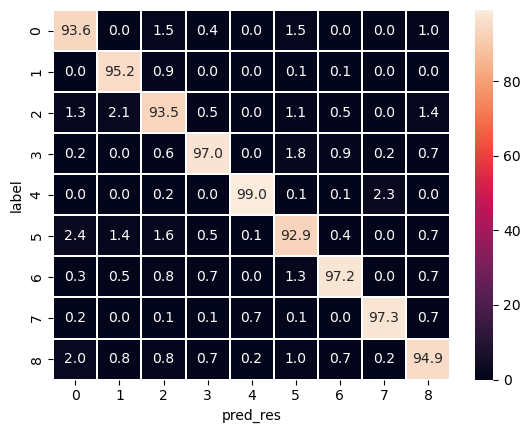

In [8]:
sns.heatmap(mt/mt.sum(axis=0) * 100, linewidths=0.1, annot=True, fmt='.1f')
plt.xlabel('pred_res')
plt.ylabel('label')
plt.show()

# pred_res, y_res

In [9]:
foucs_on = """
class 0, 5, 8
"""
[idx2sp[i] for i in [0, 5, 8]]

['RedFox', 'Badger', 'AmurLeopard']

In [10]:
# 0: 'RedFox',   5: 'Badger',  8 :'AmurLeopard'
y_res, pred_res = np.array(y_res), np.array(pred_res)
pred_score_c = np.concatenate(pred_score) 

np.arange(len(pred_res))[
    (pred_res == 5) & (y_res != 5)
], np.array(y_res)[ # [idx2sp[i] for i in 
    (pred_res == 5) & (y_res != 5)
]
# , [idx2sp[i] for i in  np.array(y_res)[ # 
#     (pred_res == 5) & (y_res != 5)
# ]]

(array([  44,  124,  145,  233,  244,  401,  419,  467, 1407, 1413, 1499,
        1586, 1616, 1626, 1671, 1677, 1807, 1866, 1885, 1891, 1903, 1907,
        2781, 2889, 3593, 3623, 3627, 3654, 3662, 3935, 4230, 4305, 4483,
        4821, 4957, 5024, 5040, 5138, 5248, 5301, 5362, 5373, 5419, 5457,
        5511, 5653, 5654, 5722, 5779, 5800, 5817, 5841, 5953, 5978, 6002,
        6637]),
 array([8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        7, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]))

In [11]:
pred_score_c.sum(axis=1, keepdims=True).shape

(7152, 1)

In [12]:
def sftmax(a):
    dim_ = a.shape[1]
    return np.round(np.exp(a/np.sqrt(dim_)) / np.exp(a/np.sqrt(dim_)).sum(axis=1, keepdims=True), 3)

pred_score_sft = sftmax(pred_score_c)
pred_score_sft[-3]

array([0.005, 0.001, 0.008, 0.004, 0.909, 0.002, 0.005, 0.049, 0.016],
      dtype=float32)

In [13]:
tt_dataset.files[44].name # 图像前景较多 可以用双边滤波处理
tt_dataset.files[124].name # 夜晚，且只有一半的身体
tt_dataset.files[145].name # 夜晚，图像模糊
tt_dataset.files[233].name # 只有一半的身体  可以对预估较好的样本进行裁剪
tt_dataset.files[244].name # 只有一半的身体  可以对预估较好的样本进行裁剪
tt_dataset.files[401].name # 只有一半的身体  可以对预估较好的样本进行裁剪 
tt_dataset.files[5841].name # 前景比较多 (并且颜色比较接近)
tt_dataset.files[4821].name # 夜晚 黑白 右上角有颜色
tt_dataset.files[5978].name # picture not clean
tt_dataset.files[6002].name # picture not clean


'RedFox_3 (136).jpg'

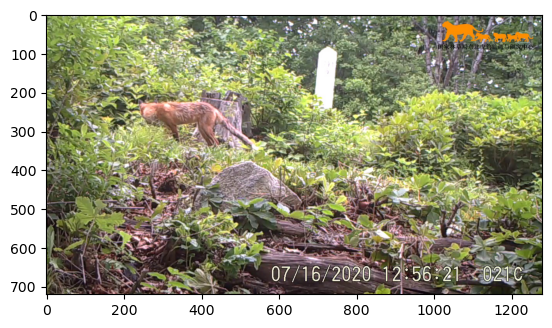

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


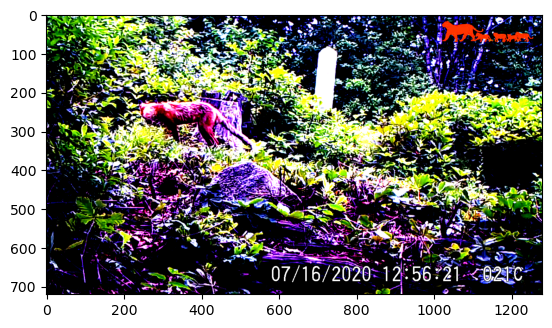

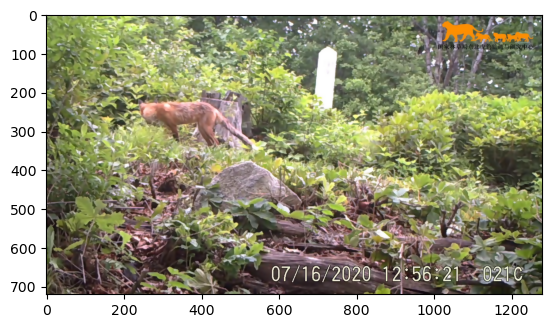

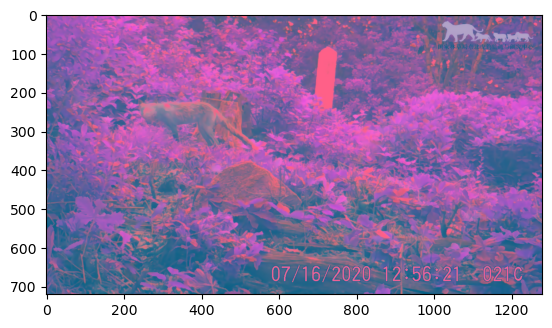

In [13]:
from PIL import Image 
import matplotlib.pyplot as plt 
import cv2

pic = tt_dataset.files[5841]

def rgb_norm(image):
    r, g, b = cv2.split(image)
    r = (r - np.mean(r)) / np.std(r)
    g = (g - np.mean(g)) / np.std(g)
    b = (b - np.mean(b)) / np.std(b)
    return cv2.merge((r, g, b))

im = Image.open(pic).convert('RGB')
plt.imshow(np.array(im))
plt.show()

# 5978 
im_change = rgb_norm(np.array(im))
plt.imshow(im_change)
plt.show()

# bilateral_image
bilateral_image = cv2.bilateralFilter(np.array(im), 9, 75, 75)
plt.imshow(bilateral_image)
plt.show()


# im_change = rgb_norm(bilateral_image)
# plt.imshow(im_change)
# plt.show()


# COLOR_RGB2LUV
image_luv = cv2.cvtColor(np.array(bilateral_image), cv2.COLOR_RGB2LUV)
plt.imshow(image_luv)
plt.show()

In [14]:
# pred best 
f_label = 0
idx = np.arange(len(pred_res))[
    (pred_res == f_label) & (y_res == f_label)
]

a = pred_score_sft[  
    (pred_res == f_label) & (y_res == f_label)
, f_label]

idx[np.argsort(a)][-20:]

array([5812, 5427, 5813, 5861, 5712, 5738, 5639, 5644, 5850, 5441, 5433,
       5860, 5657, 5788, 5434, 5466, 5896, 5601, 5854, 5859])

In [15]:
pred_score_sft[267, f_label]

0.001

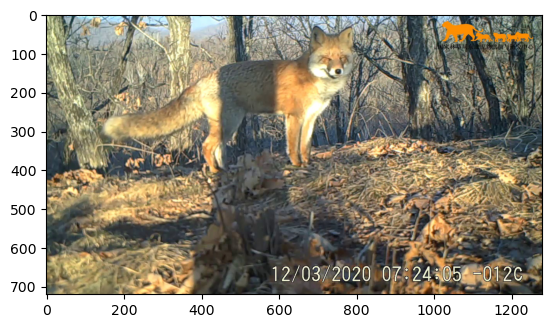

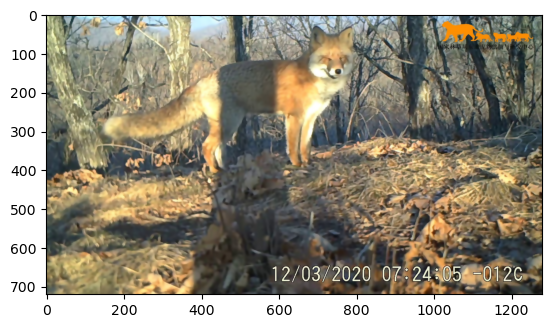

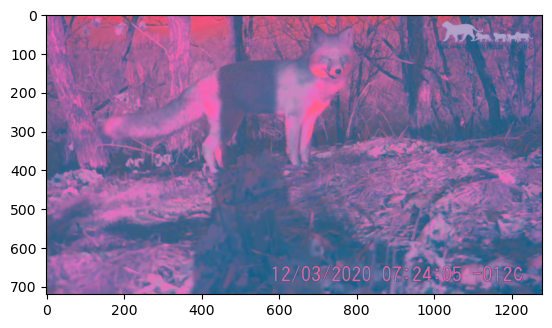

In [16]:
pic = tt_dataset.files[5639]


im = Image.open(pic).convert('RGB')
plt.imshow(np.array(im))
plt.show()

# # 5978 
# im_change = rgb_norm(np.array(im))
# plt.imshow(im_change)
# plt.show()

# bilateral_image
bilateral_image = cv2.bilateralFilter(np.array(im), 9, 75, 75)
plt.imshow(bilateral_image)
plt.show()


# im_change = rgb_norm(bilateral_image)
# plt.imshow(im_change)
# plt.show()


# COLOR_RGB2LUV
image_luv = cv2.cvtColor(np.array(bilateral_image), cv2.COLOR_RGB2LUV)
plt.imshow(image_luv)
plt.show()

In [17]:
# best_model.features
import torchvision.transforms as transforms


pic_pt = test_add_norm_tfm(Image.fromarray(bilateral_image)).to(device)
pic_org_pt = test_add_norm_tfm(im).to(device)
best_model.eval()
res = best_model(pic_pt.unsqueeze(0))
res1 = best_model(pic_org_pt.unsqueeze(0))

In [18]:
torch.argmax(res), torch.argmax(res1) , res[0][2], res1[0][2]

(tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(-0.5928, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(-0.2244, device='cuda:0', grad_fn=<SelectBackward0>))

In [19]:
def normalize(image):
    # maxMinScale
    return (image - image.min()) / (image.max() - image.min())


def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.cuda()

    # 允许x进行微分计算
    x.requires_grad_()

    y_pred = model(x)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda())
    loss.backward()

    # saliencies = x.grad.abs().detach().cpu()
    # 拿取梯度最大值 (batch, channels, height, width) -> (batch, height, width) 
    saliencies, _ = torch.max(x.grad.data.abs().detach().cpu(), dim=1)

    # 对每个图片单独进行归一化： 因为它们的梯度可能在比例上有所不同
    saliencies = torch.stack([normalize(item) for item in saliencies])
    return saliencies

In [20]:
pic_pt = test_add_norm_tfm(Image.fromarray(bilateral_image)).to(device)
res_sl = compute_saliency_maps(pic_pt.unsqueeze(0), torch.tensor([f_label]), best_model)

In [ ]:
f_label, idx2sp[f_label], pic_pt.shape

(0, 'RedFox')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


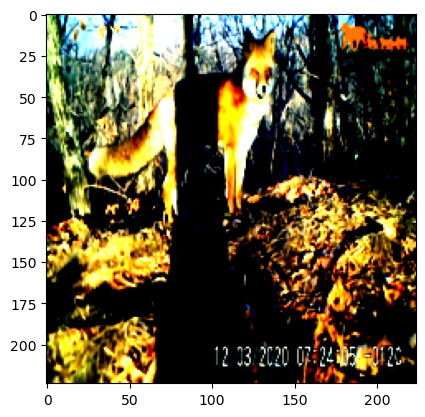

In [22]:
plt.imshow( np.transpose(pic_pt.detach().cpu().numpy(), (1, 2, 0)))
plt.show()

In [24]:
res_sl.permute(1, 2, 0).shape

torch.Size([224, 224, 1])

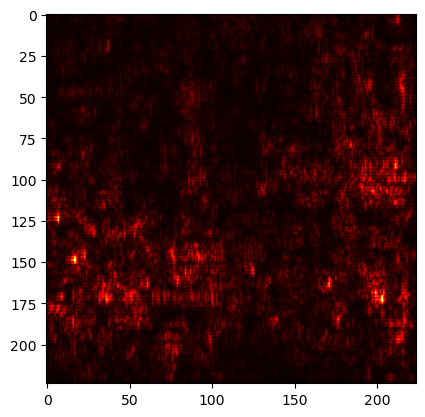

In [25]:
plt.imshow(res_sl.permute(1, 2, 0).numpy(), cmap=plt.cm.hot)
plt.show()